# Spotify Wrapped: Milestone 2

## Libraries

In [1]:
!pip install fastavro kafka-python
!pip install fastavro
!pip install arrow
!pip install faker
!pip install pycountry-convert
!pip install azure.storage.queue
!pip install pyspark
!pip install azure.eventhub
!pip install findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.5/246.5 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f7c0fa4d4142c58a50c5d050d54f18c46cc910a963b413f0fbed3098

In [18]:
from fastavro import parse_schema
from fastavro import writer, reader
from google.colab import drive
import pandas as pd
import numpy as np
import uuid
import datetime
import random, os
from faker import Faker
from azure.storage.queue import QueueServiceClient, QueueClient
from azure.core.exceptions import ResourceExistsError
from google.colab import drive
from collections import Counter
from pyspark.sql import functions as F
from pyspark.sql.functions import session_window
from pyspark.sql.functions import window
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.avro.functions import from_avro
import os, time
import findspark
import pyspark
import json
from pyspark.sql.functions import col, to_timestamp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import date_format
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import weekofyear
from azure.storage.queue import QueueServiceClient
from azure.core.exceptions import ResourceExistsError
import io
import base64
from pyspark.sql.avro.functions import from_avro, to_avro
from azure.storage.queue import QueueClient
from pyspark.sql import Row
import fastavro
from pyspark.sql.types import *
from azure.storage.queue import QueueServiceClient
from azure.core.exceptions import ResourceExistsError
import io
import base64
from pyspark.sql.avro.functions import from_avro, to_avro
from azure.storage.queue import QueueClient
from pyspark.sql import Row
import fastavro
from pyspark.sql.functions import col, desc
from pyspark.sql.streaming import StreamingQuery
from azure.eventhub import EventHubProducerClient, EventData
from azure.eventhub import EventHubProducerClient, EventData
import os
from pyspark.sql.functions import col
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## Kafka Set up

In [3]:
%%writefile environment.sh
#!/usr/bin/bash
export KAFKA_BINARY_VERSION='3.7.0'
export SCALA_BINARY_VERSION='2.13'
export KAFKA_BINARY_VERSION=$KAFKA_BINARY_VERSION
export SCALA_BINARY_VERSION=$SCALA_BINARY_VERSION
export PATH=$PATH:$PWD/kafka_$SCALA_BINARY_VERSION-$KAFKA_BINARY_VERSION/bin

Writing environment.sh


In [4]:
%%writefile kafka_setup.sh
source ./environment.sh
echo kafka_$SCALA_BINARY_VERSION-$KAFKA_BINARY_VERSION
echo $PATH

# Java Setup
wget -O- https://apt.corretto.aws/corretto.key | sudo apt-key add -
sudo add-apt-repository 'deb https://apt.corretto.aws stable main' -y
sudo apt-get -y update; sudo apt-get install -y java-11-amazon-corretto-jdk

# Kafka Setup
wget https://downloads.apache.org/kafka/${KAFKA_BINARY_VERSION}/kafka_${SCALA_BINARY_VERSION}-${KAFKA_BINARY_VERSION}.tgz
tar xzf kafka_${SCALA_BINARY_VERSION}-${KAFKA_BINARY_VERSION}.tgz

UUID=$(./kafka_${SCALA_BINARY_VERSION}-${KAFKA_BINARY_VERSION}/bin/kafka-storage.sh random-uuid)
echo "export UUID=$UUID" >> ./environment.sh
cat environment.sh

# Start Kafka Broker

echo kafka_$SCALA_BINARY_VERSION-$KAFKA_BINARY_VERSION

# offsets.retention.minutes determines how long Kafka retains the commit offsets for consumer groups.
echo "offsets.retention.minutes=300" >> ./kafka_${SCALA_BINARY_VERSION}-${KAFKA_BINARY_VERSION}/config/kraft/server.properties

./kafka_${SCALA_BINARY_VERSION}-${KAFKA_BINARY_VERSION}/bin/kafka-storage.sh format -t ${UUID} -c ./kafka_${SCALA_BINARY_VERSION}-${KAFKA_BINARY_VERSION}/config/kraft/server.properties
nohup ./kafka_${SCALA_BINARY_VERSION}-${KAFKA_BINARY_VERSION}/bin/kafka-server-start.sh ./kafka_${SCALA_BINARY_VERSION}-${KAFKA_BINARY_VERSION}/config/kraft/server.properties > kafka_server.log &

Writing kafka_setup.sh


In [5]:
%%shell
source kafka_setup.sh
sleep 10
tail -20 kafka_server.log

kafka_2.13-3.7.0
/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/content/kafka_2.13-3.7.0/bin
--2024-04-14 19:31:09--  https://apt.corretto.aws/corretto.key
Resolving apt.corretto.aws (apt.corretto.aws)... 52.84.18.105, 52.84.18.101, 52.84.18.14, ...
Connecting to apt.corretto.aws (apt.corretto.aws)|52.84.18.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1695 (1.7K) [binary/octet-stream]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.66K  --.-KB/s    in 0s      

2024-04-14 19:31:10 (914 MB/s) - written to stdout [1695/1695]

OK
Repository: 'deb https://apt.corretto.aws stable main'
Description:
Archive for codename: stable components: main
More info: https://apt.corretto.aws
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/archive_uri-https_apt_corretto_aws-jammy.list
Adding disabled deb-src entry to /etc/apt

In [6]:
%%shell
source ./environment.sh
kafka-topics.sh --bootstrap-server 127.0.0.1:9092 --topic spotifywrapped --create --partitions 6 --replication-factor 1

Created topic spotifywrapped.


In [7]:
%%writefile check_kafka_consumers.sh
#!/usr/bin/env bash
source ./environment.sh

echo "Active Consumer Groups"
while true
do
date
kafka-consumer-groups.sh --bootstrap-server 127.0.0.1:9092 --describe --all-groups
sleep 1
done

Writing check_kafka_consumers.sh


In [8]:
%%shell
chmod +x ./check_kafka_consumers.sh
nohup ./check_kafka_consumers.sh > kafka_consumers.log &

nohup: redirecting stderr to stdout


In [9]:
drive.mount('/content/drive')

Mounted at /content/drive


### Kafka Producer of Spotify Wrapped AVRO Records

In [10]:
%%writefile avro_producer.py
#!/usr/bin/python
# Import the required modules
from kafka import KafkaProducer
import fastavro
import io
import pandas as pd
import uuid
import datetime
import random, os
from faker import Faker
import numpy as np
import pycountry_convert as pc
import datetime
from collections import defaultdict

schema = {
  "doc": "Spotify Wrapped 2024",
  "name": "SpotifyData",
  "namespace": "com.spotify.wrapped",
  "type": "record",
  "fields": [
    {"name": "userId", "type": "string"},
    {"name": "songId", "type": "int"},
    {"name": "songName", "type": "string"},
    {"name": "genre", "type": "string"},
    {"name": "originalDuration", "type": "int"},
    {"name": "releaseDate", "type": "int"},
    {"name": "popularity", "type": "int"},
    {"name": "artist", "type": "string"},
    {"name": "artistID", "type": "int"},
    {"name": "interactionTimestamp", "type": "string"},
    {"name": "location", "type": "string"},
    {"name": "continent", "type": "string"},
    {
      "name": "interactionType",
      "type": {
        "type": "enum",
        "name": "InteractionType",
        "symbols": ["play", "leave_app"]
      }
    },
    {"name": "listeningPersonality", "type": "string"},
    {
      "name": "subscriptionType",
      "type": {
        "type": "enum",
        "name": "SubscriptionType",
        "symbols": ["Free", "Premium", "Family"]
      }
    }
  ]
}


# Parse the updated schema
from fastavro import parse_schema
parsed_updated_schema = parse_schema(schema)


commonality = pd.read_csv("/content/drive/MyDrive/data/commonality.csv")
exploration = pd.read_csv("/content/drive/MyDrive/data/exploration.csv")
familiarity = pd.read_csv("/content/drive/MyDrive/data/familiarity.csv")
loyalty = pd.read_csv("/content/drive/MyDrive/data/loyalty.csv")
newness = pd.read_csv("/content/drive/MyDrive/data/newness.csv")
timelessness = pd.read_csv("/content/drive/MyDrive/data/timelessness.csv")
uniqueness = pd.read_csv("/content/drive/MyDrive/data/uniqueness.csv")
variety = pd.read_csv("/content/drive/MyDrive/data/variety.csv")


personality_datasets = {
    'fe': [('F', familiarity), ('E', exploration)],
    'tn': [('T', timelessness), ('N', newness)],
    'lv': [('L', loyalty), ('V', variety)],
    'cu': [('C', commonality), ('U', uniqueness)]
}

listening_personalities = {
    'ENVC': 'The Early Adopter',
    'ENLU': 'The Nomad',
    'FNVU': 'The Specialist',
    'FNLC': 'The Enthusiast',
    'FTLC': 'The Connoisseur',
    'FTVU': 'The Deep Diver',
    'FNVC': 'The Fanclubber',
    'ETLC': 'The Top Charter',
    'FTLU': 'The Replayer',
    'FTVC': 'The Jukeboxer',
    'ENLC': 'The Voyager',
    'FNLU': 'The Devotee',
    'ETLU': 'The Maverick',
    'ETVU': 'The Time Traveler',
    'ETVC': 'The Musicologist',
    'ENVU': 'The Adventurer',
}


def get_continent_by_country(country_name):
    try:
        country_code = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return "Unknown"  # Returns "Unknown" if country name is not found or conversion fails

def get_recognized_country(fake):
    while True:
        country_name = fake.country()
        try:
            # Attempt to convert the country name to a continent
            pc.country_name_to_country_alpha2(country_name)
            continent_name = get_continent_by_country(country_name)
            if continent_name != "Unknown":
              return country_name  # Return the name if conversion is successful
        except:
            pass  # If conversion fails, retry with another country


def generate_user_data(userid, start_time, end_time, personality_datasets, listening_personalities, subscription_types):
    fake = Faker()
    lam = 3  # lambda for exponential distribution, implying a song approximately every three minutes
    current_time = start_time
    records = []

    location = get_recognized_country(fake)  # Use the new function to get a recognized country
    continent = get_continent_by_country(location)  # Automatically determine continent based on location
    subscription_type = fake.random_element(elements=tuple(subscription_types))

    selected_datasets = {}
    selected_identifiers = []
    personality_key = ''

    personality_datasetsv2=personality_datasets

    # Select datasets and their identifiers
    for personality, datasets in personality_datasetsv2.items():
      selected = random.choice(datasets)
      identifier, dataset = selected
      selected_datasets[personality] = dataset
      selected_identifiers.append(identifier)
      personality_key += identifier
    listening_personality = listening_personalities.get(personality_key, '')
    combined_dataset = pd.concat([df for df in selected_datasets.values()])

    combined_dataset.iloc[:, [0, 2, 5, 6, 7]] = combined_dataset.iloc[:, [0, 2, 5, 6, 7]].replace({',': ''}, regex=True).astype(int)
    combined_dataset.iloc[:, [1, 3, 4]] = combined_dataset.iloc[:, [1, 3, 4]].astype(str)

    # Generate and collect records
    while current_time <= end_time:
        random_number = random.randint(0, combined_dataset.shape[0] - 1)
        interaction_type = "play" if current_time < end_time else "leave_app"
        record = {
            "userId": userid,
            "songId": combined_dataset.iloc[random_number, 0],
            "songName": combined_dataset.iloc[random_number, 1],
            "genre": combined_dataset.iloc[random_number, 4],
            "originalDuration": combined_dataset.iloc[random_number, 6],
            "releaseDate": combined_dataset.iloc[random_number, 5],
            "popularity": combined_dataset.iloc[random_number, 7],
            "artist": combined_dataset.iloc[random_number, 3],
            "artistID": combined_dataset.iloc[random_number, 2],
            "interactionTimestamp": current_time.strftime('%Y-%m-%d %H:%M:%S'),
            "location": location,
            "continent": continent,
            "interactionType": interaction_type,
            "listeningPersonality": listening_personality,
            "subscriptionType": subscription_type
        }
        records.append(record)

        # Update time for next record
        if interaction_type == "play":
            inter_arrival_time = np.random.exponential(scale=lam)
            current_time += datetime.timedelta(minutes=inter_arrival_time)
            if current_time >= end_time:
                # Ensure the last interaction is 'leave_app'
                record["interactionType"] = "leave_app"
                break

    return records


def generate_multiple_user_data(start_day, end_day, personality_datasets, listening_personalities, subscription_types, partitions, producer, topic_name):
    lam_arrival = 1/0.05  # rate = 0.05 every minute
    current_time = start_day
    all_user_records = []
    lam_service_duration = 20  # average session duration of 20 minutes

    while current_time < end_day:
        # Generate inter-arrival time for new user sessions
        inter_arrival_time_user = np.random.exponential(scale=lam_arrival)
        user_start_time = current_time + datetime.timedelta(minutes=inter_arrival_time_user)
        current_time = user_start_time

        # Simulate each user's session length (e.g., between 30 and 120 minutes)
        session_length = datetime.timedelta(minutes=max(np.random.exponential(scale=lam_service_duration), 5))
        user_end_time = user_start_time + session_length

        # Adjust the end time if it exceeds the simulation period
        if user_end_time > end_day:
            user_end_time = end_day

        # Generate a unique user_id for each session
        user_personality_df = pd.read_csv("/content/drive/MyDrive/data/user_personality_df.csv")
        user_id = random.choice(user_personality_df['user_id'].tolist())

        # Generate data for an individual user session
        user_data = generate_user_data(user_id, user_start_time, user_end_time, personality_datasets, listening_personalities, subscription_types)
        all_user_records.extend(user_data)
        for record in user_data:
          continent=record["continent"]
          producer.send(
            topic_name,
            value=record,
            partition=partitions[continent])

    return all_user_records

# Create a Kafka producer with value serializer
def serialize(user_data):
  print("Serialize:" + str(user_data))
  schemaless_bytes_writer = io.BytesIO()
  fastavro.schemaless_writer(schemaless_bytes_writer, schema, user_data)
  return schemaless_bytes_writer.getvalue()

producer = KafkaProducer(
    bootstrap_servers=['127.0.0.1:9092'],
    value_serializer=serialize
)


# topic name is a command line argument, if not present it defaults to spotifywrapped
import sys
topic_name_default="spotifywrapped"
if len(sys.argv) > 1:
  topic_name = sys.argv[1]
else:
  topic_name = topic_name_default

subscription_types = ["Free", "Premium", "Family"]  # Example subscription types
records=defaultdict(list)

records["Asia"]
records["Europe"]
records["Africa"]
records["North America"]
records["Oceania"]
records["South America"]
records["Antarctica"]
partitions={ continent: partition_id for partition_id, continent in enumerate(records.keys()) }
partitions["Antarctica"]=4

start_day = datetime.datetime.now()
end_day = start_day + datetime.timedelta(hours=8640)
all_data = generate_multiple_user_data(start_day, end_day, personality_datasets, listening_personalities, subscription_types, partitions, producer, topic_name)

producer.flush()

Writing avro_producer.py


In [11]:
!nohup python avro_producer.py > avro_producer.log &

nohup: redirecting stderr to stdout


In [12]:
!sleep 5
!tail -40 avro_producer.log

Serialize:{'userId': '395fd8a4-e7e8-45ad-936c-f2363b0559fe', 'songId': 1842, 'songName': 'Folsom Prison Blues', 'genre': 'arkansas country', 'originalDuration': 156, 'releaseDate': 1964, 'popularity': 58, 'artist': 'Johnny Cash', 'artistID': 1053, 'interactionTimestamp': '2024-04-15 05:25:50', 'location': 'Cyprus', 'continent': 'Asia', 'interactionType': 'play', 'listeningPersonality': 'The Fanclubber', 'subscriptionType': 'Premium'}
Serialize:{'userId': '395fd8a4-e7e8-45ad-936c-f2363b0559fe', 'songId': 34, 'songName': "Don't Know Why", 'genre': 'adult standards', 'originalDuration': 186, 'releaseDate': 2002, 'popularity': 74, 'artist': 'Norah Jones', 'artistID': 1000, 'interactionTimestamp': '2024-04-15 05:27:17', 'location': 'Cyprus', 'continent': 'Asia', 'interactionType': 'play', 'listeningPersonality': 'The Fanclubber', 'subscriptionType': 'Premium'}
Serialize:{'userId': '395fd8a4-e7e8-45ad-936c-f2363b0559fe', 'songId': 279, 'songName': 'Munich', 'genre': 'alternative dance', 'ori

### Kafka Consumer

In [13]:
%%writefile avro_consumer.py
#!/usr/bin/python
# Import the required modules
from kafka import KafkaConsumer
import fastavro
import io
import pandas as pd
import uuid
import datetime
import random, os
from faker import Faker
import numpy as np
from azure.storage.queue import QueueClient
from fastavro import schemaless_writer
import io
import base64
from datetime import datetime

schema = {
  "doc": "Spotify Wrapped 2024",
  "name": "SpotifyData",
  "namespace": "com.spotify.wrapped",
  "type": "record",
  "fields": [
    {"name": "userId", "type": "string"},
    {"name": "songId", "type": "int"},
    {"name": "songName", "type": "string"},
    {"name": "genre", "type": "string"},
    {"name": "originalDuration", "type": "int"},
    {"name": "releaseDate", "type": "int"},
    {"name": "popularity", "type": "int"},
    {"name": "artist", "type": "string"},
    {"name": "artistID", "type": "int"},
    {"name": "interactionTimestamp", "type": "string"},
    {"name": "location", "type": "string"},
    {"name": "continent", "type": "string"},
    {
      "name": "interactionType",
      "type": {
        "type": "enum",
        "name": "InteractionType",
        "symbols": ["play", "leave_app"]
      }
    },
    {"name": "listeningPersonality", "type": "string"},
    {
      "name": "subscriptionType",
      "type": {
        "type": "enum",
        "name": "SubscriptionType",
        "symbols": ["Free", "Premium", "Family"]
      }
    }
  ]
}


# Parse the updated schema
from fastavro import parse_schema
parsed_updated_schema = parse_schema(schema)

# Create a Kafka producer with value serializer
def deserialize(message):
  # print("Deserialize:" + str(message))

  import io
  schemaless_bytes_reader = io.BytesIO(message)
  try:
    record=fastavro.schemaless_reader(schemaless_bytes_reader, schema)
    return record
  except Exception as ex:
    print(ex)
    return "pass"

# Create a Kafka consumer with value deserializer
# topic name is a command line argument, if not present it defaults to spotifywrapped
import sys
topic_name_default="spotifywrapped"
if len(sys.argv) > 1:
  topic_name = sys.argv[1]
else:
  topic_name = topic_name_default

consumer = KafkaConsumer(
    topic_name,
    bootstrap_servers=['localhost:9092'],
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    group_id='Python_AVRO_Consumer',
    value_deserializer=deserialize #lambda v: fastavro.schemaless_reader(io.BytesIO(v), schema)
)

#Consume messages from the topic and print them
for message in consumer:
    print("="*10)
    print(message.value)

Writing avro_consumer.py


In [14]:
!nohup python avro_consumer.py > avro_consumer.log &

nohup: redirecting stderr to stdout


In [15]:
!sleep 5
!tail -20 avro_consumer.log

{'userId': '7857dfb6-3404-4657-8b15-23209138ff8a', 'songId': 1827, 'songName': 'Hey Boy Hey Girl', 'genre': 'alternative dance', 'originalDuration': 290, 'releaseDate': 1999, 'popularity': 65, 'artist': 'The Chemical Brothers', 'artistID': 1695, 'interactionTimestamp': '2024-04-16 18:07:00', 'location': 'Switzerland', 'continent': 'Europe', 'interactionType': 'play', 'listeningPersonality': 'The Nomad', 'subscriptionType': 'Free'}
{'userId': '7857dfb6-3404-4657-8b15-23209138ff8a', 'songId': 700, 'songName': 'Everything Now', 'genre': 'alternative dance', 'originalDuration': 303, 'releaseDate': 2017, 'popularity': 66, 'artist': 'Arcade Fire', 'artistID': 1353, 'interactionTimestamp': '2024-04-16 18:12:18', 'location': 'Switzerland', 'continent': 'Europe', 'interactionType': 'play', 'listeningPersonality': 'The Nomad', 'subscriptionType': 'Free'}
{'userId': '7857dfb6-3404-4657-8b15-23209138ff8a', 'songId': 63, 'songName': 'Smoorverliefd', 'genre': 'dutch cabaret', 'originalDuration': 195

In [16]:
import time
time.sleep(10)

## Spark Set up

In [19]:
spark_release='spark-3.5.1'
hadoop_version='hadoop3'

start=time.time()
os.environ['SPARK_RELEASE']=spark_release
os.environ['HADOOP_VERSION']=hadoop_version
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_release}-bin-{hadoop_version}"
# Run below commands in google colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # install Java8
!wget -q http://apache.osuosl.org/spark/${SPARK_RELEASE}/${SPARK_RELEASE}-bin-${HADOOP_VERSION}.tgz # download spark-3.3.X
!tar xf ${SPARK_RELEASE}-bin-${HADOOP_VERSION}.tgz # unzip it

!pip install -q findspark # install findspark
# findspark find your Spark Distribution and sets necessary environment variables

findspark.init()

# Check the pyspark version
print(pyspark.__version__)

3.5.1


### Define the Configuration Details of the Spark job

In [20]:
kafka_brokers="127.0.0.1:9092" # Can be a comma-separated list of brokers 127.0.0.1:9092
topic_name="spotifywrapped"

schema  = """ {
  "doc": "Spotify Wrapped 2024",
  "name": "SpotifyData",
  "namespace": "com.spotify.wrapped",
  "type": "record",
  "fields": [
    {"name": "userId", "type": "string"},
    {"name": "songId", "type": "int"},
    {"name": "songName", "type": "string"},
    {"name": "genre", "type": "string"},
    {"name": "originalDuration", "type": "int"},
    {"name": "releaseDate", "type": "int"},
    {"name": "popularity", "type": "int"},
    {"name": "artist", "type": "string"},
    {"name": "artistID", "type": "int"},
    {"name": "interactionTimestamp", "type": "string"},
    {"name": "location", "type": "string"},
    {"name": "continent", "type": "string"},
    {
      "name": "interactionType",
      "type": {
        "type": "enum",
        "name": "InteractionType",
        "symbols": ["play", "leave_app"]
      }
    },
    {"name": "listeningPersonality", "type": "string"},
    {
      "name": "subscriptionType",
      "type": {
        "type": "enum",
        "name": "SubscriptionType",
        "symbols": ["Free", "Premium", "Family"]
      }
    }
  ]
}"""

# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("StreamingAVROFromKafka") \
    .config("spark.streaming.stopGracefullyOnShutdown", True) \
    .config("spark.sql.streaming.statefulOperator.checkCorrectness.enabled", "false") \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0,org.apache.spark:spark-avro_2.12:3.5.0') \
    .config("spark.sql.shuffle.partitions", 4) \
    .master("local[*]") \
    .getOrCreate()

kafkaConf = {
    "kafka.bootstrap.servers": kafka_brokers,
    # Below settins required if kafka is secured:
    # "kafka.sasl.mechanism": "PLAIN",
    # "kafka.security.protocol": "SASL_SSL",
    # "kafka.sasl.jaas.config": 'org.apache.kafka.common.security.plain.PlainLoginModule required username="$ConnectionString" password="Endpoint=sb://eventhubname.servicebus.windows.net/;SharedAccessKeyName=listenpolicyforspark;SharedAccessKey=ckNkSjcyXKGN8FCIRIS3qtkKvW+AEhB6QPaM=;EntityPath=instructortest";',
    "subscribe": topic_name, # to read from specific partitions use option: "assign": {topic_name:[0,1]})
    "startingOffsets": "earliest", # "earliest", "latest"
    "enable.auto.commit": "true ",
    "groupIdPrefix": "Stream_Analytics_",
    "auto.commit.interval.ms": "5000"
}

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [21]:
# Now we flatten the AVRO record to put each field in a separate column:
df = spark \
    .readStream \
    .format("kafka") \
    .options(**kafkaConf)
df = df.load()
df = df.select(from_avro(df.value, schema).alias("spotify"))

In [22]:
df.printSchema()

root
 |-- spotify: struct (nullable = true)
 |    |-- userId: string (nullable = false)
 |    |-- songId: integer (nullable = false)
 |    |-- songName: string (nullable = false)
 |    |-- genre: string (nullable = false)
 |    |-- originalDuration: integer (nullable = false)
 |    |-- releaseDate: integer (nullable = false)
 |    |-- popularity: integer (nullable = false)
 |    |-- artist: string (nullable = false)
 |    |-- artistID: integer (nullable = false)
 |    |-- interactionTimestamp: string (nullable = false)
 |    |-- location: string (nullable = false)
 |    |-- continent: string (nullable = false)
 |    |-- interactionType: string (nullable = false)
 |    |-- listeningPersonality: string (nullable = false)
 |    |-- subscriptionType: string (nullable = false)



In [23]:
df = df.select(
    col("spotify.userId"),
    col("spotify.songId"),
    col("spotify.songName"),
    col("spotify.genre"),
    col("spotify.location"),
    col("spotify.continent"),
    col("spotify.originalDuration"),
    col("spotify.releaseDate"),
    col("spotify.popularity"),
    col("spotify.artist"),
    col("spotify.artistID"),
    to_timestamp(col("spotify.interactionTimestamp"), "yyyy-MM-dd HH:mm:ss").alias("interactionTimestamp"),
    col("spotify.interactionType"),
    col("spotify.listeningPersonality"),
    col("spotify.subscriptionType")
)

df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- songId: integer (nullable = true)
 |-- songName: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- location: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- originalDuration: integer (nullable = true)
 |-- releaseDate: integer (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- artist: string (nullable = true)
 |-- artistID: integer (nullable = true)
 |-- interactionTimestamp: timestamp (nullable = true)
 |-- interactionType: string (nullable = true)
 |-- listeningPersonality: string (nullable = true)
 |-- subscriptionType: string (nullable = true)



In [24]:
!mkdir checkpoint

## 3 Main Stakeholders: Spotify (Internal Use), Spotify Users, Spotify Artists

### Group Analysis 1: Spotify (Internal Use)

#### Subanalysis 1: Predictions (1 model and 2 datasets)

**First Dataset: Count of Users For Every 1-week Window**

The model predicts the number of users in the next week.

In [ ]:
df_user_count_per_minute = df.groupBy(window(df.interactionTimestamp, "10080 minute")
).agg(
    F.approx_count_distinct("userId").alias("userCount")
).select(
    F.col("window.start").alias("windowStart"),
    F.col("userCount")
).orderBy("window.start", ascending=True)

# Now define the streaming query to output this aggregation
query_user_count_per_minute = df_user_count_per_minute \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("user_count") \
    .start()

#the query is outputted in panda after!!

In [ ]:
x=spark.sql("select * from user_count").toPandas()
x
# Load your dataset (assuming it's already been converted to a Pandas DataFrame)
x2 = x
print(x)

   windowStart  userCount
0   2024-04-11        230
1   2024-04-18        449
2   2024-04-25        447
3   2024-05-02        510
4   2024-05-09        547
5   2024-05-16        449
6   2024-05-23        541
7   2024-05-30        538
8   2024-06-06        461
9   2024-06-13        484
10  2024-06-20        486
11  2024-06-27        474
12  2024-07-04        447
13  2024-07-11        479
14  2024-07-18        502
15  2024-07-25        516
16  2024-08-01        451
17  2024-08-08        492
18  2024-08-15        471
19  2024-08-22        432
20  2024-08-29        476
21  2024-09-05        456
22  2024-09-12        518
23  2024-09-19        486
24  2024-09-26        466
25  2024-10-03        481
26  2024-10-10        447
27  2024-10-17        524
28  2024-10-24        456
29  2024-10-31        524
30  2024-11-07        492
31  2024-11-14        541
32  2024-11-21        502
33  2024-11-28        492
34  2024-12-05        461
35  2024-12-12        451
36  2024-12-19        481
37  2024-12-

In [ ]:
x=spark.sql("select * from user_count").toPandas()
x
# Load your dataset (assuming it's already been converted to a Pandas DataFrame)
x2 = x

# Normalize the userCount column
scaler = MinMaxScaler(feature_range=(0, 1))
user_counts_scaled = scaler.fit_transform(x2[['userCount']].values)

# Convert to a time series problem
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 3
X, y = create_dataset(user_counts_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into train and test sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = y[0:train_size], y[train_size:len(y)]

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=100, batch_size=32, verbose=1)

# Make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

Epoch 1/100


Exception ignored in: <function JavaObject.__init__.<locals>.<lambda> at 0x78ccd12024d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1359, in <lambda>
    lambda wr, cc=self._gateway_client, id=self._target_id:
KeyboardInterrupt: 


2/2 [==============================] - 86s 11s/step - loss: 0.6658 - val_loss: 0.6031
Epoch 2/100
2/2 [==============================] - 1s 539ms/step - loss: 0.6064 - val_loss: 0.5456
Epoch 3/100
2/2 [==============================] - 1s 528ms/step - loss: 0.5491 - val_loss: 0.4892
Epoch 4/100
2/2 [==============================] - 1s 492ms/step - loss: 0.4922 - val_loss: 0.4324
Epoch 5/100
2/2 [==============================] - 1s 533ms/step - loss: 0.4353 - val_loss: 0.3742
Epoch 6/100
2/2 [==============================] - 1s 455ms/step - loss: 0.3773 - val_loss: 0.3149
Epoch 7/100
2/2 [==============================] - 1s 666ms/step - loss: 0.3178 - val_loss: 0.2551
Epoch 8/100
2/2 [==============================] - 1s 502ms/step - loss: 0.2581 - val_loss: 0.1956
Epoch 9/100
2/2 [==============================] - 1s 464ms/step - loss: 0.1986 - val_loss: 0.1380
Epoch 10/100
2/2 [==============================] - 0s 376ms/step - loss: 0.1413 - val_loss: 0.0856
Epoch 11/100
2/2 [====

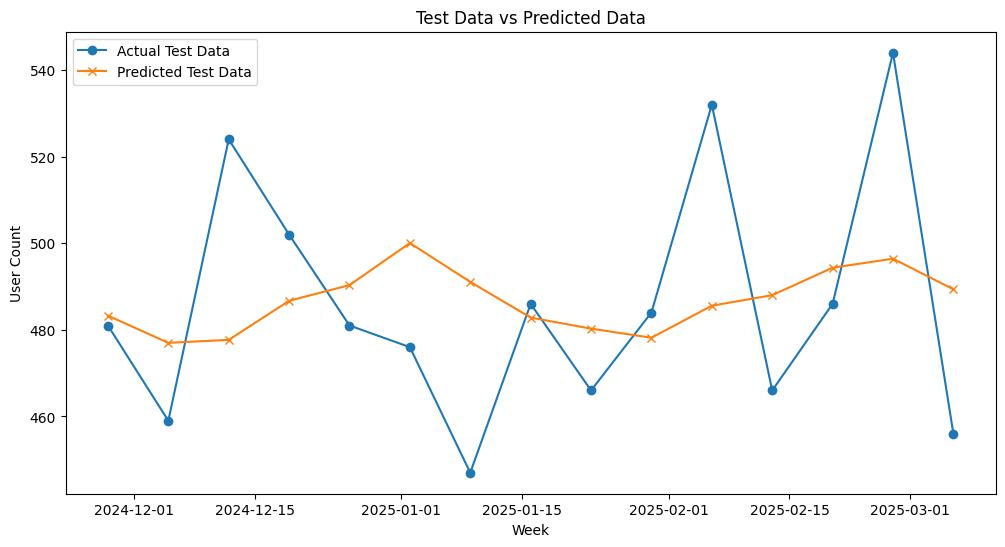

In [ ]:
# Generate some example data for demonstration purposes
# In your actual code, replace these with your real data
actual_test_data = scaler.inverse_transform(testY.reshape(-1, 1))
predicted_test_data = test_predict

# Make sure that the length of actual and predicted data is the same
assert len(actual_test_data) == len(predicted_test_data), "The lengths of actual and predicted data must match."

# Create an index for the x-axis
time_steps = pd.to_datetime(x['windowStart'][train_size:train_size + len(actual_test_data)])

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(time_steps, actual_test_data, label='Actual Test Data', marker='o')
plt.plot(time_steps, predicted_test_data, label='Predicted Test Data', marker='x')

# Add title and labels
plt.title('Test Data vs Predicted Data')
plt.xlabel('Week')
plt.ylabel('User Count')

# Add a legend to help us differentiate between the two lines
plt.legend()

# Show the plot
plt.show()

**Second Dataset: Count of Session Per Day**

 This line groups events into sessions per user. A session window is defined by a period of activity followed by inactivity. Here, a new session is started if there's a gap of more than 10 minutes between events. So, if a user is inactive for more than 10 minutes, the next event from that user starts a new session. This grouping operation creates a new session window for each user based on their activity.

In [ ]:
# Using window for sessionization along with user grouping
sessionized = df.groupBy(
    session_window(df.interactionTimestamp, "10 minutes"),  # 10-minute windows for sessionization
    col("userId")
).agg(
    F.count("*").alias("interactionsCount")  # Count interactions per session per user
).select("session_window")


sessionsPerDay = sessionized.withColumn(
    "sessionDate",
    date_format(col("session_window").start, "yyyy-MM-dd")  # Format the start time of window as date
).groupBy(
    "sessionDate"
).agg(F.count("*").alias("sessionsPerDay")  # Sum interactions to get total per day
).orderBy("sessionDate", ascending=True)

In [ ]:
query_test = sessionsPerDay \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("test") \
    .start()

In [ ]:
xsession=spark.sql("select * from test")

Epoch 1/100
8/8 [==============================] - 75s 2s/step - loss: 0.3101 - val_loss: 0.2066
Epoch 2/100
8/8 [==============================] - 1s 81ms/step - loss: 0.1683 - val_loss: 0.0784
Epoch 3/100
8/8 [==============================] - 1s 86ms/step - loss: 0.0500 - val_loss: 0.0286
Epoch 4/100
8/8 [==============================] - 1s 120ms/step - loss: 0.0395 - val_loss: 0.0399
Epoch 5/100
8/8 [==============================] - 1s 109ms/step - loss: 0.0313 - val_loss: 0.0258
Epoch 6/100
8/8 [==============================] - 1s 134ms/step - loss: 0.0295 - val_loss: 0.0276
Epoch 7/100
8/8 [==============================] - 0s 49ms/step - loss: 0.0302 - val_loss: 0.0256
Epoch 8/100
8/8 [==============================] - 1s 191ms/step - loss: 0.0279 - val_loss: 0.0264
Epoch 9/100
8/8 [==============================] - 1s 114ms/step - loss: 0.0284 - val_loss: 0.0260
Epoch 10/100
8/8 [==============================] - 1s 195ms/step - loss: 0.0277 - val_loss: 0.0253
Epoch 11/100
8

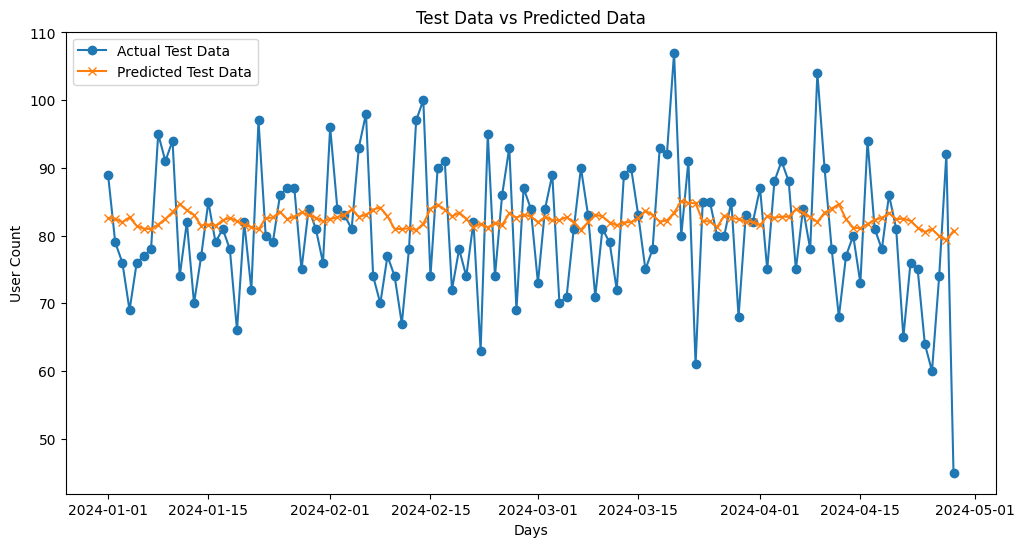

In [ ]:
xsessionp=xsession.toPandas()

# Assuming xsession is a Spark DataFrame with a column 'windowStart' for dates
xsessionp = xsession.toPandas()

# Normalize the userCount column
scaler = MinMaxScaler(feature_range=(0, 1))
user_counts_scaled = scaler.fit_transform(xsessionp[['sessionsPerDay']].values)

# Convert to a time series problem
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 3
X, y = create_dataset(user_counts_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into train and test sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:]
trainY, testY = y[0:train_size], y[train_size:]

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=100, batch_size=32, verbose=1)

# Make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

actual_test_data = scaler.inverse_transform(testY.reshape(-1, 1))
predicted_test_data = test_predict

assert len(actual_test_data) == len(predicted_test_data), "The lengths of actual and predicted data must match."

# Adjust time_steps generation
if 'windowStart' in xsessionp.columns:
    time_steps = pd.to_datetime(xsessionp['windowStart'][train_size+time_step:train_size+time_step+len(actual_test_data)])
else:
    # Generate placeholder dates starting in 2024 if windowStart is missing
    time_steps = pd.date_range(start='1/1/2024', periods=len(actual_test_data), freq='D')

plt.figure(figsize=(12, 6))
plt.plot(time_steps, actual_test_data, label='Actual Test Data', marker='o')
plt.plot(time_steps, predicted_test_data, label='Predicted Test Data', marker='x')
plt.title('Test Data vs Predicted Data')
plt.xlabel('Days')
plt.ylabel('User Count')
plt.legend()
plt.show()

#### Subanalysis 2:  Fraud Messages and Heavy Users

##### Heavy Free Users

When the user is in the top 5 %, then he is considered as a potential user.

In [ ]:
time.sleep(60)

In [ ]:
sessionizedCounts = df.filter(df.subscriptionType == "Free") \
    .groupBy(F.session_window(col("interactionTimestamp"), "10 minutes"), col("userId")) \
    .agg(F.count("userId").alias("distinct_sessions"))

# Extract the start week from the session window for each session
sessionsPerWeek = sessionizedCounts.withColumn(
    "startWeek",
    weekofyear(col("session_window").start)
).groupBy(
    "startWeek", "userId"
).agg(
    F.count("distinct_sessions").alias("sessionsPerWeek")
).orderBy("sessionsPerWeek", ascending=False)


query_user_count_per_session = sessionsPerWeek \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("user_count_session3") \
    .start()

In [ ]:
sqlquery="SELECT * FROM user_count_session3"
sqlquery="""
SELECT userId, percentile
FROM (
    SELECT userId,
           PERCENT_RANK() OVER (PARTITION BY startWeek ORDER BY sessionsPerWeek DESC) AS percentile
    FROM user_count_session3
) tmp
ORDER BY percentile DESC
LIMIT 10
"""

In [ ]:
heavyuser=spark.sql(sqlquery)
heavyuser.show(10)

+--------------------+------------------+
|              userId|        percentile|
+--------------------+------------------+
|f910edde-1bcb-476...|0.9880952380952381|
|1d2dcfce-8cd1-4b7...|0.9880952380952381|
|6bf6731b-9f02-4d0...|0.9880952380952381|
|c1a259cc-b38a-40c...|0.9515151515151515|
|81e606e1-4dbc-499...|0.9515151515151515|
|291d1431-e665-408...|0.9515151515151515|
|f6c0224e-70a8-4c6...|0.9515151515151515|
|d3ac0f67-50d2-4c9...|0.9515151515151515|
|0b92342e-020f-4c6...|0.9515151515151515|
|324de6a3-a6ec-4e9...|0.9515151515151515|
+--------------------+------------------+



In [ ]:
heavyuserdf=heavyuser.toPandas()

  userId  percentile
0  User1        0.99
1  User2        0.99
2  User3        0.99
3  User4        0.95
4  User5        0.95


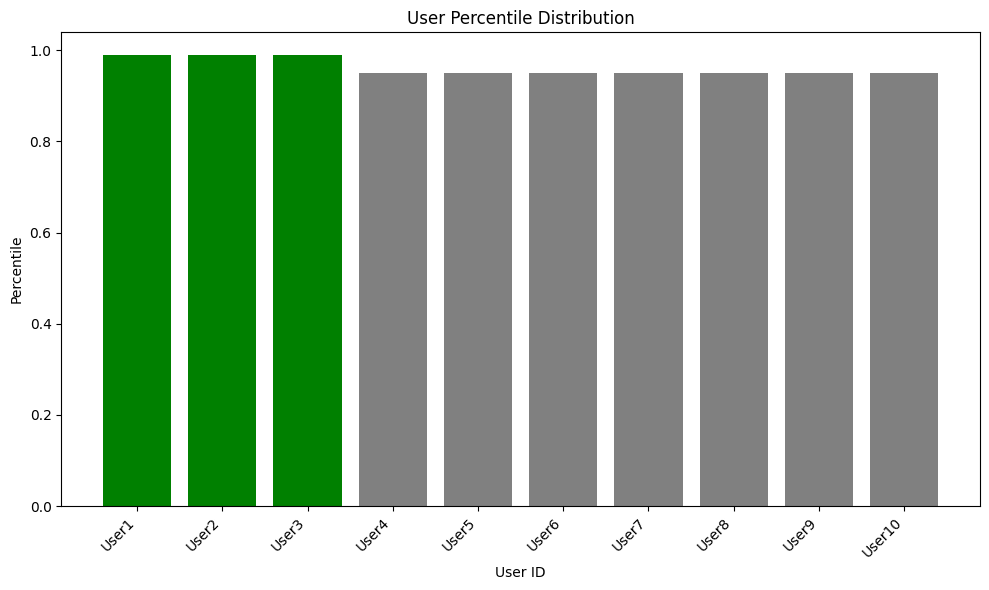

In [ ]:
# Assuming 'heavyuserdf' is your pandas DataFrame.
# Reset the index of the DataFrame to make sure it starts from 0.
heavyuserdf.reset_index(drop=True, inplace=True)

# Create the 'usersimple' column by concatenating 'User' with the index + 1.
heavyuserdf['userId'] = 'User' + (heavyuserdf.index + 1).astype(str)
heavyuserdf.head(10)
heavyuserdf['percentile']=heavyuserdf['percentile']
heavyuserdf['percentile'] = heavyuserdf['percentile'].round(2)
print(heavyuserdf.head())

colors = ['green' if x > 0.98 else 'grey' for x in heavyuserdf['percentile']]

# Creating the bar chart
plt.figure(figsize=(10, 6)) # Adjust the size as needed
plt.bar(heavyuserdf['userId'], heavyuserdf['percentile'], color=colors)

# Adding names for x and y axis, and a title
plt.xlabel('User ID')
plt.ylabel('Percentile')
plt.title('User Percentile Distribution')

# Improving the x-axis labels to better fit, especially if you have many userIds
plt.xticks(rotation=45, ha="right")

plt.tight_layout() # Adjusts subplot params to give some padding
plt.show()

In [ ]:
account_name = 'iesststreamanalytics0001'
account_key = 'pG+SGulHMre57nd0bG2OAzTXp22VyBprS6alDDqem+1DHQWrucMuOriS7i+ZJ46PwPKNjHcIQJH7+AStY1E/tQ=='
username = 'dtroje'

# The use of `.format()` is unnecessary here as you're using f-string already
connection_string = f"DefaultEndpointsProtocol=https;AccountName={account_name};AccountKey={account_key};EndpointSuffix=core.windows.net"

queues1 = f"{username}-heavyfreeuser"

queue_service_client = QueueServiceClient.from_connection_string(conn_str=connection_string)

try:
    queue_service_client.create_queue(queues1)
except ResourceExistsError:
    print(f"{queues1} already exists!.")
else:
    print(f"{queues1} created!.")

In [ ]:
# Define your schema with the appropriate fields
schema = {
    "doc": "User Count Data",
    "name": "UserData",
    "namespace": "com.example.userdata",
    "type": "record",
    "fields": [
        {"name": "userId", "type":  "string"},
        {"name": "percentile", "type": "double"}
    ]
}

# Assuming parse_schema is a function that parses the schema for use in serialization
# Here it should be from fastavro
parsed_updated_schema = fastavro.parse_schema(schema)

# Create the queue client
queue_client = QueueClient.from_connection_string(conn_str=connection_string, queue_name=queues1)

# Serialize and send each row of the DataFrame to the Azure Queue
for row in heavyuser.collect():
    # Convert row to dictionary
    record = {'userId': row['userId'], 'percentile': row['percentile']}

    # Serialize record using Avro schema
    bytes_writer = io.BytesIO()
    fastavro.schemaless_writer(bytes_writer, parsed_updated_schema, record)

    # Get the bytes value of the serialized data
    serialized_record = bytes_writer.getvalue()

    # Convert the serialized data to base64 string as Azure Queue Message need to be in this format
    encoded_message = base64.b64encode(serialized_record).decode()

    # Send message to the queue
    try:
        queue_client.send_message(encoded_message)
        print(f"Message for user {record['userId']} sent to the queue.")
    except Exception as e:
        print(f"An error occurred while sending message to the queue: {str(e)}")

##### Fraud message
We do the interaction of each user per week joined with the interaction of teh toatal user in this week. We divide both. We get the % of each user of the total interaction per week. If an user has a huge proportion than a normal threshold then it should be flagged.

In [ ]:
# Your existing query remains largely the same, but let's also compute the total interactions per window.
# This part remains unchanged
query_global_user = (
    df.select("userID", "interactionTimestamp")\
    .groupBy("userID", F.window("interactionTimestamp", "10080 minute"))\
    .count()\
    .withColumnRenamed('count', 'userCount')
)

# Calculate the total interactions per window for all users.
total_interactions_per_window = (df.select("userID", "interactionTimestamp")
    .groupBy(F.window("interactionTimestamp", "10080 minute"))
    .count()
    .withColumnRenamed('count', 'totalInteractions')
    .withColumnRenamed('window', 'window1')  # Renaming for clarity # Renaming for clarity in subsequent operations)
)

In [ ]:
total_interactions_per_w=(total_interactions_per_window
.writeStream
.format ("memory")
.outputMode ("update" )
.queryName ("join_demo_05")
.start())

total__per_window=(query_global_user
.writeStream
.format ("memory")
.outputMode ("update" )
.queryName ("join_demo_07")
.start())

In [ ]:
join_query = """
SELECT j07.userID,
       ROUND((j07.userCount / j05.totalInteractions),6) AS percentage_activity
FROM join_demo_05 j05
INNER JOIN join_demo_07 j07
ON j05.window1.start = j07.window.start AND
   j05.window1.end = j07.window.end
ORDER BY percentage_activity DESC
LIMIT 10
"""

In [ ]:
joined_df = spark.sql(join_query)
joined_df.show(20, truncate=False)

+------------------------------------+-------------------+
|userID                              |percentage_activity|
+------------------------------------+-------------------+
|dc4c9de4-4e50-40e2-8e1e-644df23c5611|0.909091           |
|b258e1bb-1664-49f3-af1c-e76904cd6777|0.872727           |
|a64d104d-81be-466a-a045-a185ca2299f7|0.818182           |
|d775cf2f-feca-4236-b4d6-a1e97a9ef517|0.8                |
|cf51e8d7-e935-46d1-8405-71527623d699|0.727273           |
|37762bec-5b41-45ad-9631-a4971365fef1|0.709091           |
|79a0ff8b-d884-4a02-91b2-65a477390857|0.654545           |
|02df3968-3455-4045-8e96-384b03cae312|0.636364           |
|79cd7820-b98e-443d-af8c-7e74551ed46f|0.636364           |
|327dd4f7-a513-4112-a044-088d6dc05b53|0.6                |
+------------------------------------+-------------------+



In [ ]:
frauduserdf=joined_df.toPandas()
# Assuming 'heavyuserdf' is your pandas DataFrame.
# Reset the index of the DataFrame to make sure it starts from 0.
frauduserdf.reset_index(drop=True, inplace=True)

# Create the 'usersimple' column by concatenating 'User' with the index + 1.
frauduserdf['userID'] = 'User' + (frauduserdf.index + 1).astype(str)
frauduserdf.head(10)
frauduserdf['percentage_activity']=frauduserdf['percentage_activity']
frauduserdf['percentage_activity'] = frauduserdf['percentage_activity'].round(3)
frauduserdf.head()

,userID,percentage_activity
0,User1,0.909
1,User2,0.873
2,User3,0.818
3,User4,0.800
4,User5,0.727


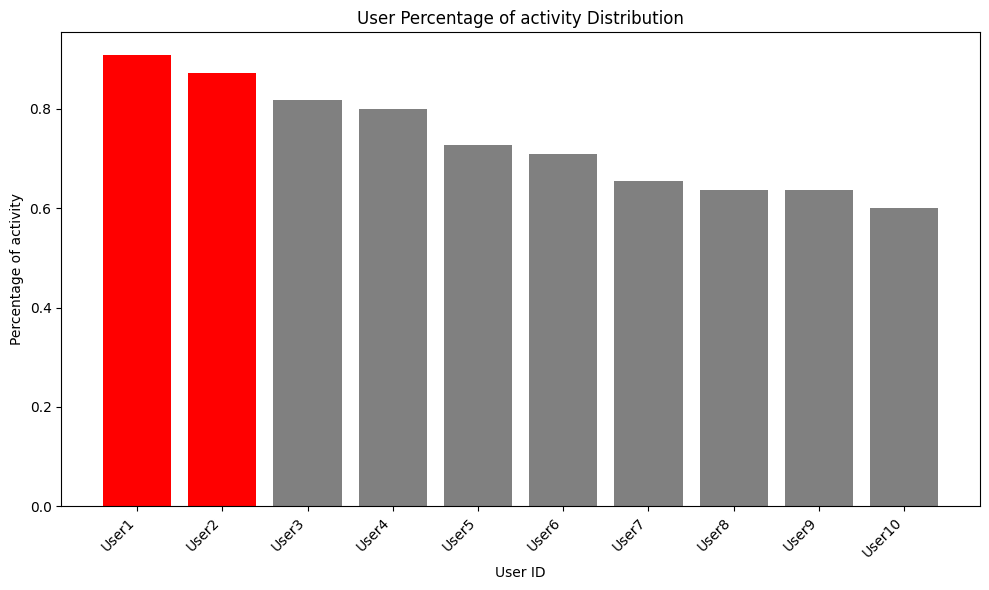

In [ ]:
colors = ['red' if x > 0.85 else 'grey' for x in frauduserdf['percentage_activity']]

# Creating the bar chart
plt.figure(figsize=(10, 6)) # Adjust the size as needed
plt.bar(frauduserdf['userID'], frauduserdf['percentage_activity'], color=colors)

# Adding names for x and y axis, and a title
plt.xlabel('User ID')
plt.ylabel('Percentage of activity')
plt.title('User Percentage of activity Distribution')

# Improving the x-axis labels to better fit, especially if you have many userIds
plt.xticks(rotation=45, ha="right")

plt.tight_layout() # Adjusts subplot params to give some padding

In [ ]:
account_name = 'iesststreamanalytics0001'
account_key = 'pG+SGulHMre57nd0bG2OAzTXp22VyBprS6alDDqem+1DHQWrucMuOriS7i+ZJ46PwPKNjHcIQJH7+AStY1E/tQ=='
username = 'dtroje'

# The use of `.format()` is unnecessary here as you're using f-string already
connection_string = f"DefaultEndpointsProtocol=https;AccountName={account_name};AccountKey={account_key};EndpointSuffix=core.windows.net"

queues = f"{username}-frauduser"

queue_service_client = QueueServiceClient.from_connection_string(conn_str=connection_string)

try:
    queue_service_client.create_queue(queues)
except ResourceExistsError:
    print(f"{queues} already exists!.")
else:
    print(f"{queues} created!.")

In [ ]:
# Define your schema with the appropriate fields
schema = {
    "doc": "User Count Data",
    "name": "UserData",
    "namespace": "com.example.userdata",
    "type": "record",
    "fields": [
        {"name": "userID", "type":  "string"},
        {"name": "percentile_activity", "type": "double"}
    ]
}

# Assuming parse_schema is a function that parses the schema for use in serialization
# Here it should be from fastavro
parsed_updated_schema = fastavro.parse_schema(schema)

# Create the queue client
queue_client = QueueClient.from_connection_string(conn_str=connection_string, queue_name=queues)

# Serialize and send each row of the DataFrame to the Azure Queue
for row in joined_df.collect():
    # Convert row to dictionary
    record = {'userID': row['userID'], 'percentile_activity': row['percentile_activity']}

    # Serialize record using Avro schema
    bytes_writer = io.BytesIO()
    fastavro.schemaless_writer(bytes_writer, parsed_updated_schema, record)

    # Get the bytes value of the serialized data
    serialized_record = bytes_writer.getvalue()

    # Convert the serialized data to base64 string as Azure Queue Message need to be in this format
    encoded_message = base64.b64encode(serialized_record).decode()

    # Send message to the queue
    try:
        queue_client.send_message(encoded_message)
        print(f"Message for user {record['userID']} sent to the queue.")
    except Exception as e:
        print(f"An error occurred while sending message to the queue: {str(e)}")

In [ ]:
#run this before
active_queries = spark.streams.active

for query in active_queries:
  print(query)
  query.stop()

### Group Analysis 2: Spotify Users

######**User-Specific Stats**

Input User ID, retrieve:
*   Top 5 Artists
*   Top 5 Songs
*   Top Genre
*   Listening Personality (1 out of 16)

In [ ]:
def setup_top_artists_songs_genre(spark, userid):
    # Sanitize user ID to ensure it can be used as part of a SQL identifier
    sanitized_userid = userid.replace('-', '')

    # Generate unique query names based on the sanitized user ID
    query_personality_name = f"listening_personality_view_{sanitized_userid}"
    query_artist_name = f"top_artists_view_{sanitized_userid}"
    query_song_name = f"top_songs_view_{sanitized_userid}"
    query_genre_name = f"top_genre_view_{sanitized_userid}"


    listening_personality_query = df.filter(col("userId") == userid) \
        .select("listeningPersonality") \
        .distinct() \
        .writeStream \
        .queryName(f"listening_personality_view_{sanitized_userid}") \
        .format("memory") \
        .outputMode("update") \
        .start()

    top_artists_query = df.filter(col("userId") == userid) \
        .groupBy("artist").count() \
        .withColumnRenamed("count", "play_count") \
        .orderBy(desc("play_count")) \
        .limit(5) \
        .writeStream \
        .queryName(query_artist_name) \
        .format("memory") \
        .outputMode("complete") \
        .start()

    top_songs_query = df.filter(col("userId") == userid) \
        .groupBy("songName").count() \
        .withColumnRenamed("count", "play_count") \
        .orderBy(desc("play_count")) \
        .limit(5) \
        .writeStream \
        .queryName(query_song_name) \
        .format("memory") \
        .outputMode("complete") \
        .start()

    top_genre_query = df.filter(col("userId") == userid) \
        .groupBy("genre").count() \
        .withColumnRenamed("count", "play_count") \
        .orderBy(desc("play_count")) \
        .limit(1) \
        .writeStream \
        .queryName(query_genre_name) \
        .format("memory") \
        .outputMode("complete") \
        .start()

    return listening_personality_query, top_artists_query, top_songs_query, top_genre_query

# Example usage
user_id = '951a17cb-b4c7-4115-9677-df16199d5d88'
listening_personality_query, top_artists_query, top_songs_query, top_genre_query = setup_top_artists_songs_genre(spark, user_id)

In [ ]:
import time
time.sleep(10)

# Query the in-memory tables for results using sanitized user IDs
sanitized_user_id = user_id.replace('-', '')
spark.sql(f"SELECT * FROM listening_personality_view_{sanitized_user_id}").show(truncate=False)
spark.sql(f"SELECT * FROM top_artists_view_{sanitized_user_id}").show(truncate=False)
spark.sql(f"SELECT * FROM top_songs_view_{sanitized_user_id}").show(truncate=False)
spark.sql(f"SELECT * FROM top_genre_view_{sanitized_user_id}").show(truncate=False)

+--------------------+
|listeningPersonality|
+--------------------+
|The Devotee         |
|The Musicologist    |
+--------------------+

+------------------+----------+
|artist            |play_count|
+------------------+----------+
|Coldplay          |3         |
|The Beatles       |2         |
|The Rolling Stones|2         |
|Dire Straits      |2         |
|The Doors         |2         |
+------------------+----------+

+---------------------------+----------+
|songName                   |play_count|
+---------------------------+----------+
|Always Remember Us This Way|2         |
|On Every Street            |1         |
|Africa                     |1         |
|Knowing Me, Knowing You    |1         |
|Maid Of Orleans            |1         |
+---------------------------+----------+

+----------+----------+
|genre     |play_count|
+----------+----------+
|album rock|16        |
+----------+----------+



In [ ]:
#run this before
active_queries = spark.streams.active

for query in active_queries:
  print(query)
  query.stop()

#####**Continent-Specific Stats**

Retrieve per continent:
*   Top 3 Artists
*   Top 3 Songs
*   Top 3 Genres
*   Top 3 Artists

######Top 3 songs

In [ ]:
def setup_top_songs_stream_for_continent(continent):
    # Replace spaces with underscores for the table name
    safe_continent_name = continent.replace(" ", "_").lower()
    query = df \
        .filter(col("continent") == continent) \
        .groupBy("songName") \
        .count() \
        .withColumnRenamed("count", "playCount") \
        .orderBy(col("playCount").desc()) \
        .limit(3) \
        .writeStream \
        .queryName(f"top_3_songs_{safe_continent_name}") \
        .format("memory") \
        .outputMode("complete") \
        .start()
    return query

# List of continents
continents = ["Africa", "Asia", "Europe", "North America", "South America", "Oceania", "Antarctica"]

# Start a streaming query for each continent
queries = {continent: setup_top_songs_stream_for_continent(continent) for continent in continents}

In [ ]:
import time
time.sleep(100)  # Adjust based on your stream initialization time

for continent in continents:
    safe_continent_name = continent.replace(" ", "_").lower()
    print(f"Top 3 Songs for {continent}:")
    spark.sql(f"SELECT * FROM top_3_songs_{safe_continent_name}").show()

Top 3 Songs for Africa:
+--------------------+---------+
|            songName|playCount|
+--------------------+---------+
|                 One|       66|
|          Hallelujah|       57|
|One Kiss (with Du...|       53|
+--------------------+---------+

Top 3 Songs for Asia:
+----------+---------+
|  songName|playCount|
+----------+---------+
|High Hopes|       63|
|Hallelujah|       60|
|   Sunrise|       55|
+----------+---------+

Top 3 Songs for Europe:
+----------+---------+
|  songName|playCount|
+----------+---------+
|Hallelujah|       70|
|       One|       49|
|  Memories|       49|
+----------+---------+

Top 3 Songs for North America:
+------------+---------+
|    songName|playCount|
+------------+---------+
|         One|       45|
|Feeling Good|       44|
|  High Hopes|       42|
+------------+---------+

Top 3 Songs for South America:
+--------------------+---------+
|            songName|playCount|
+--------------------+---------+
|         Do It Again|       25|
|   

######Top 3 genres

In [ ]:
def setup_top_genres_stream_for_continent(continent):
    # Replace spaces with underscores for the table name
    safe_continent_name = continent.replace(" ", "_").lower()
    query = df \
        .filter(col("continent") == continent) \
        .groupBy("genre") \
        .count() \
        .withColumnRenamed("count", "playCount") \
        .orderBy(col("playCount").desc()) \
        .limit(3) \
        .writeStream \
        .queryName(f"top_3_genres_{safe_continent_name}") \
        .format("memory") \
        .outputMode("complete") \
        .start()
    return query

# List of continents
continents = ["Africa", "Asia", "Europe", "North America", "South America", "Oceania", "Antarctica"]

# Start a streaming query for each continent
genre_queries = {continent: setup_top_genres_stream_for_continent(continent) for continent in continents}

In [ ]:
import time
time.sleep(100)  # Adjust based on your stream initialization time

for continent in continents:
    safe_continent_name = continent.replace(" ", "_").lower()
    print(f"Top 3 Genres for {continent}:")
    spark.sql(f"SELECT * FROM top_3_genres_{safe_continent_name}").show()

Top 3 Genres for Africa:
+---------------+---------+
|          genre|playCount|
+---------------+---------+
|     album rock|     8689|
|adult standards|     2706|
|      dutch pop|     2139|
+---------------+---------+

Top 3 Genres for Asia:
+---------------+---------+
|          genre|playCount|
+---------------+---------+
|     album rock|     8319|
|adult standards|     2535|
|      dutch pop|     2118|
+---------------+---------+

Top 3 Genres for Europe:
+---------------+---------+
|          genre|playCount|
+---------------+---------+
|     album rock|     7817|
|adult standards|     2365|
|      dutch pop|     1935|
+---------------+---------+

Top 3 Genres for North America:
+---------------+---------+
|          genre|playCount|
+---------------+---------+
|     album rock|     6457|
|adult standards|     2122|
|      dutch pop|     1611|
+---------------+---------+

Top 3 Genres for South America:
+---------------+---------+
|          genre|playCount|
+---------------+--

###### Top 3 users

In [ ]:
def setup_top_users_stream_for_continent(continent):
    # Replace spaces with underscores for the table name
    safe_continent_name = continent.replace(" ", "_").lower()
    query = df \
        .filter(col("continent") == continent) \
        .groupBy("userId") \
        .count() \
        .withColumnRenamed("count", "playCount") \
        .orderBy(col("playCount").desc()) \
        .limit(3) \
        .writeStream \
        .queryName(f"top_3_users_{safe_continent_name}") \
        .format("memory") \
        .outputMode("complete") \
        .start()
    return query

# List of continents
continents = ["Africa", "Asia", "Europe", "North America", "South America", "Oceania", "Antarctica"]

# Start a streaming query for each continent
user_queries = {continent: setup_top_users_stream_for_continent(continent) for continent in continents}

In [ ]:
import time
time.sleep(10)  # Adjust based on your stream initialization time

for continent in continents:
    safe_continent_name = continent.replace(" ", "_").lower()
    print(f"Top 3 Users for {continent}:")
    spark.sql(f"SELECT * FROM top_3_users_{safe_continent_name}").show(truncate=False)

Top 3 Users for Africa:
+------------------------------------+---------+
|userId                              |playCount|
+------------------------------------+---------+
|ed50e13e-8eee-4c57-ba26-d5a130c37b56|76       |
|f28db3e4-0845-4a75-a3d8-e99333791619|74       |
|c6e2e136-f323-452d-9f7a-bd6ad07d6a44|71       |
+------------------------------------+---------+

Top 3 Users for Asia:
+------------------------------------+---------+
|userId                              |playCount|
+------------------------------------+---------+
|392f0246-4c1f-4beb-b2f5-f6d84a0518dc|86       |
|0cc4b656-bc1b-4ef9-b1a4-db7d05550efa|73       |
|1041a39c-20b5-4e40-ba09-0e04485ed565|70       |
+------------------------------------+---------+

Top 3 Users for Europe:
+------------------------------------+---------+
|userId                              |playCount|
+------------------------------------+---------+
|07e0f95a-2d28-4495-9c8e-ec47b8da1029|85       |
|d8c7359e-cc75-461c-aa3e-9e8ba8966fbd|81      

###### Top 3 Artists

In [ ]:
def setup_top_artists_stream_for_continent(continent):
    # Replace spaces with underscores for the table name
    safe_continent_name = continent.replace(" ", "_").lower()
    query = df \
        .filter(col("continent") == continent) \
        .groupBy("artist") \
        .count() \
        .withColumnRenamed("count", "playCount") \
        .orderBy(col("playCount").desc()) \
        .limit(3) \
        .writeStream \
        .queryName(f"top_3_artists_{safe_continent_name}") \
        .format("memory") \
        .outputMode("complete") \
        .start()
    return query

# List of continents
continents = ["Africa", "Asia", "Europe", "North America", "South America", "Oceania", "Antarctica"]

# Start a streaming query for each continent
artist_queries = {continent: setup_top_artists_stream_for_continent(continent) for continent in continents}

In [ ]:
import time
time.sleep(10)  # Adjust based on your stream initialization time

for continent in continents:
    safe_continent_name = continent.replace(" ", "_").lower()
    print(f"Top 3 Artists for {continent}:")
    spark.sql(f"SELECT * FROM top_3_artists_{safe_continent_name}").show()

Top 3 Artists for Africa:
+-----------+---------+
|     artist|playCount|
+-----------+---------+
|      Queen|     1247|
|The Beatles|      674|
|   Coldplay|      621|
+-----------+---------+

Top 3 Artists for Asia:
+-----------+---------+
|     artist|playCount|
+-----------+---------+
|      Queen|     1214|
|The Beatles|      651|
|   Coldplay|      601|
+-----------+---------+

Top 3 Artists for Europe:
+-----------+---------+
|     artist|playCount|
+-----------+---------+
|      Queen|     1201|
|   Coldplay|      597|
|The Beatles|      587|
+-----------+---------+

Top 3 Artists for North America:
+-----------+---------+
|     artist|playCount|
+-----------+---------+
|      Queen|      910|
|The Beatles|      476|
|   Coldplay|      439|
+-----------+---------+

Top 3 Artists for South America:
+-----------+---------+
|     artist|playCount|
+-----------+---------+
|      Queen|      372|
|The Beatles|      193|
|   Coldplay|      183|
+-----------+---------+

Top 3 Artists

In [ ]:
#run this before
active_queries = spark.streams.active

for query in active_queries:
  print(query)
  query.stop()

### Group Analysis 3: Spotify Artists

#### Artist-Specific Stats

In [ ]:
# Define the artist name globally
artist_name_of_interest = "The Beatles"

def setup_top_songs_stream_for_artist_name(artist_name):
    """
    Set up a Spark streaming query to find the top 3 songs played for a specific artist name.
    """
    query = df \
        .filter(col("artist") == artist_name) \
        .groupBy("songName") \
        .count() \
        .withColumnRenamed("count", "playCount") \
        .orderBy(col("playCount").desc()) \
        .limit(3) \
        .writeStream \
        .queryName(f"top_3_songs_for_artist_{artist_name.replace(' ', '_').lower()}") \
        .format("memory") \
        .outputMode("complete") \
        .start()
    return query

# Start a streaming query for the specified artist name
query_for_artist_name = setup_top_songs_stream_for_artist_name(artist_name_of_interest)

# Let the stream run for some time to accumulate data (adjust time as necessary)
time.sleep(100)  # Sleep time depends on the volume and velocity of incoming data

# Query the in-memory table to display the top 3 songs for the specified artist name
spark.sql(f"SELECT * FROM top_3_songs_for_artist_{artist_name_of_interest.replace(' ', '_').lower()}").show(truncate=False)

+------------------------------------------+---------+
|songName                                  |playCount|
+------------------------------------------+---------+
|I Want To Hold Your Hand - Remastered 2015|136      |
|She's Leaving Home - Remastered 2009      |100      |
|Lady Madonna - Remastered 2015            |99       |
+------------------------------------------+---------+



In [ ]:
# Define the artist name globally
artist_name_of_interest = "The Beatles"

def setup_play_count_stream_for_artist_by_continent(artist_name):
    """
    Set up a Spark streaming query to count the number of plays for a specific artist across each continent.
    """
    query = df \
        .filter(col("artist") == artist_name) \
        .groupBy("continent") \
        .count() \
        .withColumnRenamed("count", "playCount") \
        .orderBy(col("playCount").desc()) \
        .writeStream \
        .queryName(f"play_count_for_{artist_name.replace(' ', '_').lower()}_by_continent") \
        .format("memory") \
        .outputMode("complete") \
        .start()
    return query

# Start a streaming query for the specified artist name to count plays by continent
query_for_artist_play_count = setup_play_count_stream_for_artist_by_continent(artist_name_of_interest)

# Let the stream run for some time to accumulate data (adjust time as necessary)
time.sleep(10)  # Sleep time depends on the volume and velocity of incoming data

# Query the in-memory table to display the play counts for the specified artist across each continent
spark.sql(f"SELECT * FROM play_count_for_{artist_name_of_interest.replace(' ', '_').lower()}_by_continent").show()

+-------------+---------+
|    continent|playCount|
+-------------+---------+
|       Africa|      674|
|         Asia|      651|
|       Europe|      587|
|North America|      476|
|      Oceania|      306|
|South America|      193|
|   Antarctica|        9|
+-------------+---------+



#### PowerBI Using Azure Event Hub

In [ ]:
def send_to_hub(row):
    # Convert row to JSON string
    message = json.dumps(row.asDict(), default=str)

    # Create a producer client to send messages to the Event Hub
    connection_str = "Endpoint=sb://iesststreamanalytics0001.servicebus.windows.net/;SharedAccessKeyName=dtroje9;SharedAccessKey=ymaJNrRpig+gvA5ayJlPkE7iJFiWaDeCe+AEhOiUn8k=;EntityPath=eh_group_07"
    eventhub_name = 'eh_group_07'
    client = EventHubProducerClient.from_connection_string(connection_str, eventhub_name=eventhub_name)

    # Send message
    with client:
        event_data_batch = client.create_batch()
        event_data_batch.add(EventData(message))
        client.send_batch(event_data_batch)

query10 = df \
    .writeStream \
    .outputMode("update") \
    .foreach(send_to_hub) \
    .queryName("azure4") \
    .start()